# Data analysis HD blastwave

Import libraries to import data and plot it

In [1]:
import script.pyPLUTO as pp
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# some commonly used constants
CONST_mp = 1.67262171e-24  # gr

Increase rsolution of plots

In [47]:
mpl.rcParams["figure.dpi"] = 150    # about the dpi for a 15 inch 1080p laptop, makes sure the displayed plots are the real size 
#mpl.rcParams["figure.dpi"] = 600

mpl.rcParams["figure.figsize"] = (6, 3)
mpl.rcParams["axes.labelsize"] = 20

mpl.rcParams["axes.formatter.limits"] = (-4, 4)

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["xkcd:royal blue", "xkcd:vermillion", "xkcd:orange", 
                                                    "xkcd:magenta", "xkcd:lime", "xkcd:yellow", "grey"])

mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.linewidth"] = .5

mpl.rcParams["font.size"] = 12

mpl.rcParams["text.usetex"] = True


#mpl.rcParams["figure.facecolor"] = "#fffbf0"
#mpl.rcParams["axes.facecolor"] = "#fffbf0"
#mpl.rcParams["savefig.facecolor"] = '#fffbf0'

Usefull functions

In [3]:
def get_extent(file, firstline):
    """this functions retrieves the extent of the grid (in code-units) and number of points from the grid.out 
    file in one dimension (starting at firstline)
    
    file: the grid.out file
    firstline: the line in the file to look for the number of points in that dimension"""
    with open(file, "r") as gridfile:
        lines = gridfile.readlines()
        # get the number of points
        NUM_POINTS = int(lines[firstline])

        # get the extent of the x-axis (in code units)
        # the first line of the grid, so minimum coordinate
        line = lines[firstline+1]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_min = float(parts[1])
        # the last line
        line = lines[firstline+NUM_POINTS]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_max = float(parts[2])
    
    return (NUM_POINTS, (d_min, d_max))

## get metadata of the simulation data

In [4]:
# specify the directories where the data is stored and where the output should be stored
DATA_DIR_1 = "data/25d-low-pressure/"
DATA_DIR_2 = "data/25d-high-pressure/"
OUT_DIR = "images/"

# define the conversion factors, can be seen when starting the simulation
UNIT_DENSITY = 1e9*CONST_mp
UNIT_LENGTH = 1e8 # cm (1AU)
UNIT_VELOCITY = 1e8 # cm/s
UNIT_TIME = UNIT_LENGTH/UNIT_VELOCITY
UNIT_PRESSURE = 1.673e1   # dyne/cm^2

In [6]:
# get info about the stored data
file_data = pd.read_csv(DATA_DIR_1+"dbl.out", sep=" ", names=["index", "t", "dt", "step", "type", "little", "rho",
                                                            "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"])
# delete columns that are not needed
for column in ["index", "type", "little", "rho", "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"]:
    del file_data[column]

X_POINTS = 0
Y_POINTS = 0
X_EXTENT = (0,0)
Y_EXTENT = (0,0)

# get the extend of the grid
# get the extent of the x-axis (in code units)
X_POINTS, X_EXTENT = get_extent(DATA_DIR_1+"grid.out", 9)
# get the extent of the y-axis
Y_POINTS, Y_EXTENT = get_extent(DATA_DIR_1+"grid.out", 10+X_POINTS)

# number of files saved
N = len(file_data["t"])

# physical extent of the grid
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH for value in extent_temp]
# physical time data
T = file_data["t"].values*UNIT_TIME

## Calculate wave speed

Get the distance on different times

In [19]:
THETA = np.linspace(0, 2*np.pi, 30, endpoint=False)
circle = (X_POINTS-1)/2+np.array([[np.cos(theta), np.sin(theta)] for theta in THETA])*(X_POINTS/2-10)

BACKGROUND_PRS = 1.0
mult = 1.05

dist_arr_1 = []
max_prs_1 = []
dist_arr_2 = []
max_prs_2 = []

for i in range(51):
    D1 = pp.pload(i, w_dir=DATA_DIR_1)
    D2 = pp.pload(i, w_dir=DATA_DIR_2)
    coord_arr_1 = []
    coord_arr_2 = []
    # loop over all directions
    for point in circle:
        direction = (point-X_POINTS/2)/X_POINTS
        
        # find value for low pressure
        val = 0
        step = 0
        # loop over all points in this direction until the center is reached, or a point
        # with prs > 1.05*background is found
        while step <= X_POINTS and val < mult*BACKGROUND_PRS:
            coordinate = point - direction*step
            val = D1.prs[int(coordinate[0]), int(coordinate[1])]
            step += 1
        coord_arr_1.append([int(coordinate[0]), int(coordinate[1])])
        
        # find value for high pressure
        val = 0
        step = 0
        # loop over all points in this direction until the center is reached, or a point
        # with prs > 1.05*background is found
        while step <= X_POINTS and val < mult*BACKGROUND_PRS:
            coordinate = point - direction*step
            val = D2.prs[int(coordinate[0]), int(coordinate[1])]
            step += 1
        coord_arr_2.append([int(coordinate[0]), int(coordinate[1])])
    # calculate the distances
    wave_front = np.array(coord_arr_1) - (X_POINTS-1)/2
    dist_arr_1.append( np.sqrt(wave_front[:,0]**2 + wave_front[:,1]**2) )
    max_prs_1.append(np.max(D1.prs))
    wave_front = np.array(coord_arr_2) - (X_POINTS-1)/2
    dist_arr_2.append( np.sqrt(wave_front[:,0]**2 + wave_front[:,1]**2) )
    max_prs_2.append(np.max(D2.prs))
    
dists1 = np.array(dist_arr_1)
dists2 = np.array(dist_arr_2)

Reading Data file : data/25d-low-pressure/data.0000.dbl
Reading Data file : data/25d-high-pressure/data.0000.dbl
Reading Data file : data/25d-low-pressure/data.0001.dbl
Reading Data file : data/25d-high-pressure/data.0001.dbl
Reading Data file : data/25d-low-pressure/data.0002.dbl
Reading Data file : data/25d-high-pressure/data.0002.dbl
Reading Data file : data/25d-low-pressure/data.0003.dbl
Reading Data file : data/25d-high-pressure/data.0003.dbl
Reading Data file : data/25d-low-pressure/data.0004.dbl
Reading Data file : data/25d-high-pressure/data.0004.dbl
Reading Data file : data/25d-low-pressure/data.0005.dbl
Reading Data file : data/25d-high-pressure/data.0005.dbl
Reading Data file : data/25d-low-pressure/data.0006.dbl
Reading Data file : data/25d-high-pressure/data.0006.dbl
Reading Data file : data/25d-low-pressure/data.0007.dbl
Reading Data file : data/25d-high-pressure/data.0007.dbl
Reading Data file : data/25d-low-pressure/data.0008.dbl
Reading Data file : data/25d-high-pressu

### Fit lines through array of distances

In [20]:
def line(x, a, b):
    return a*x+b

params1 = []
params2 = []
START = 5
STOP = 15

for i in range(len(THETA)):
    Y = dists1[START:STOP,i]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)*UNIT_LENGTH
    
    param, covar = curve_fit(line, T[START:STOP], Y, (1e8, 7.5e7))
    
    params1.append( param )
    
for i in range(len(THETA)):
    Y = dists2[START:STOP,i]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)*UNIT_LENGTH
    
    param, covar = curve_fit(line, T[START:STOP], Y, (1e8, 7.5e7))
    
    params2.append( param )

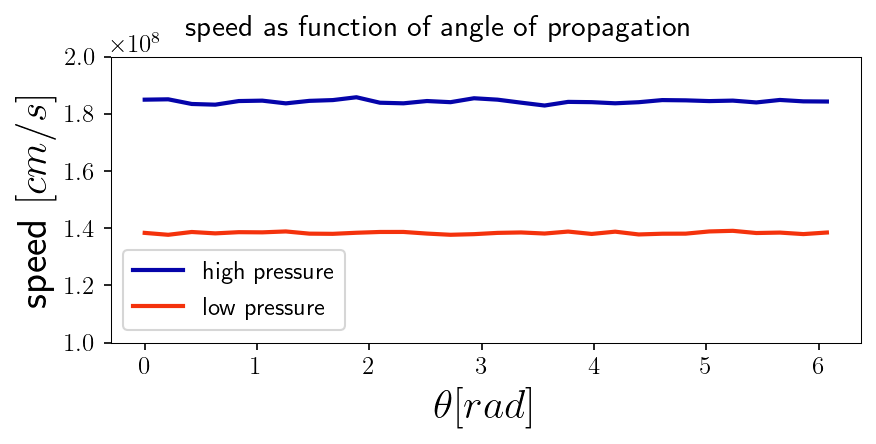

In [56]:
fig, ax = plt.subplots(1,1)

speeds1 = np.array(params1)[:,0]
speeds2 = np.array(params2)[:,0]

ax.plot(THETA, speeds2, label="high pressure")
ax.plot(THETA, speeds1, label="low pressure")

ax.set_ylim(1e8,2e8)
ax.set_ylabel(r"speed $[cm/s]$")
ax.set_xlabel(r"$\theta [rad]$")
fig.suptitle("speed as function of angle of propagation")
plt.legend()

plt.tight_layout()
plt.show()

fig.savefig("../verslag/images/speed-angle-hd.pdf")

In [9]:
m = 1.5
np.sqrt(5/3*(1+m)/2)*UNIT_VELOCITY

144337567.29740646

Snelheid gesimuleerde golf is bijna exact gelijk aan $$v_s = \sqrt{\gamma \frac{p_{min}+p_{max}}{2}}v_0 $$
met $p_{min}$ de lage druk rond de golf, $p_{max}$ de hoogste druk van de golf en $v_0$ de unit velocity voor de simulatie

### Calculate wavespeed with formula above

In [32]:
v_sim1 = []
v_theory1 = []
v_sim2 = []
v_theory2 = []

for i in range(2,39):
    # get the speed from the simulation by fitting a line
    Y = dists1[i-2:i+3,1]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)*UNIT_LENGTH
    param, covar = curve_fit(line, T[i-2:i+3], Y, (1e8, 7.5e7))
    v_sim1.append( param[0] )
    
    # calculate the speed with above formula
    v_theory1.append( np.sqrt(5/3*(1+max_prs_1[i])/2)*UNIT_VELOCITY )
    
for i in range(2,39):
    # get the speed from the simulation by fitting a line
    Y = dists2[i-2:i+3,1]*(X_EXTENT[1]-X_EXTENT[0])/(X_POINTS-1)*UNIT_LENGTH
    param, covar = curve_fit(line, T[i-2:i+3], Y, (1e8, 7.5e7))
    v_sim2.append( param[0] )
    
    # calculate the speed with above formula
    v_theory2.append( np.sqrt(5/3*(1+max_prs_2[i])/2)*UNIT_VELOCITY )

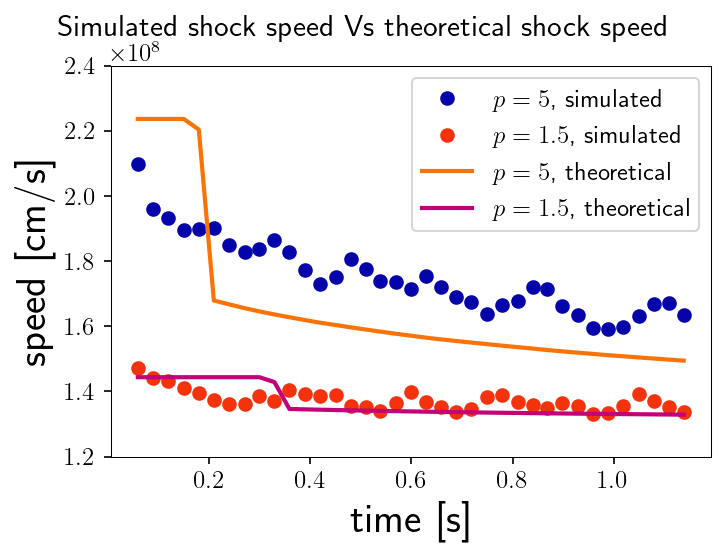

In [55]:
fig, ax = plt.subplots(1,1, figsize=(5,3.7))

ax.plot(T[2:39], v_sim2, "o", label="$p=5$, simulated")
ax.plot(T[2:39], v_sim1, "o", label="$p=1.5$, simulated")
ax.plot(T[2:39], v_theory2, label="$p=5$, theoretical")
ax.plot(T[2:39], v_theory1, label="$p=1.5$, theoretical")

ax.set_ylim(1.2e8,2.4e8)

ax.set_xlabel("time [s]")
ax.set_ylabel("speed [cm/s]")
fig.suptitle("Simulated shock speed Vs theoretical shock speed", y=1)

plt.legend()

plt.tight_layout()
plt.show()

fig.savefig("../verslag/images/speed-time-hd.pdf")

Test isotropie snelheid golf

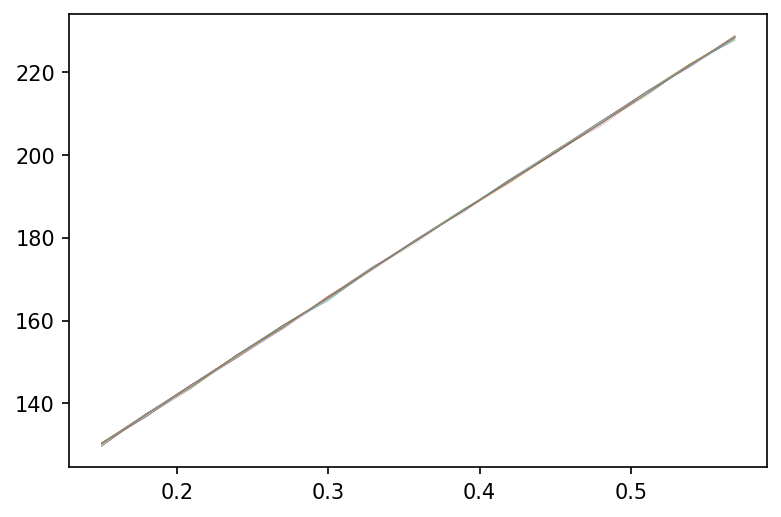

In [31]:
fig, ax = plt.subplots(1,1)

for i in range(len(THETA)):
    ax.plot(T[5:20],dists[:,i], linewidth=0.1)